In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('image-generation-gans')
jovian.set_colab_id('1bzmvvFNRCLEWTlvBmg-JjhQe_yts0ZDF')

     |████████████████████████████████| 71kB 5.1MB/s 


# Image generation GANs - Anime Face Generation


## Downloading and Exploring the data

Download dataset from kaggle using opendataset 

In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

  1%|▏         | 5.00M/395M [00:00<00:12, 31.6MB/s]

100%|██████████| 395M/395M [00:05<00:00, 82.3MB/s]


In [4]:
import os

DATA_DIR = './animefacedataset'
os.listdir(DATA_DIR)

['images']

In [5]:
print(os.listdir(DATA_DIR + '/images')[:10])

['39458_2012.jpg', '10883_2005.jpg', '16006_2006.jpg', '51502_2015.jpg', '1333_2001.jpg', '37325_2012.jpg', '13830_2006.jpg', '61013_2018.jpg', '36563_2012.jpg', '56722_2017.jpg']


## Load the data

In [6]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tfs

In [7]:
image_size = 64
batch_size = 128
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [8]:
train_ds = ImageFolder(DATA_DIR, transform=tfs.Compose([
                 tfs.Resize(image_size),
                 tfs.CenterCrop(image_size),
                 tfs.ToTensor(),
                 tfs.Normalize(*stats)                                       
]))

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=2,
                      pin_memory=True)

Let's create some helper functions to denormalize the images and display some images from training batch

In [9]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [11]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images,_ in dl:
        show_images(images, nmax)
        break

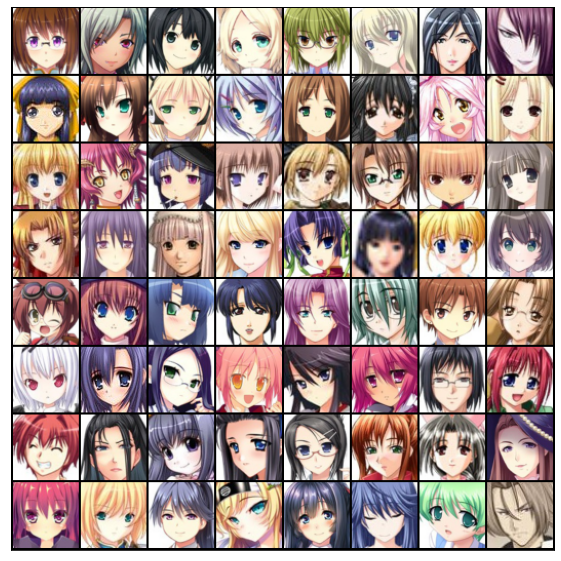

In [12]:
show_batch(train_dl)

## Using a GPU

In [13]:
def get_default_device():
  """Pick GPU if availabel, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """ Wrap a dataloader to move data into device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """ Yeild a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """ Number of batches"""
    return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator Network

In [16]:
import torch.nn as nn

In [17]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=0),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=0),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=0),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1


    nn.Flatten(),
    nn.Sigmoid())

Using Sigmoid for binary classification problem

In [19]:
discriminator = to_device(discriminator, device)
discriminator

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

## Generator Network

In [20]:
latent_size = 128

In [21]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 256 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 64, 64])


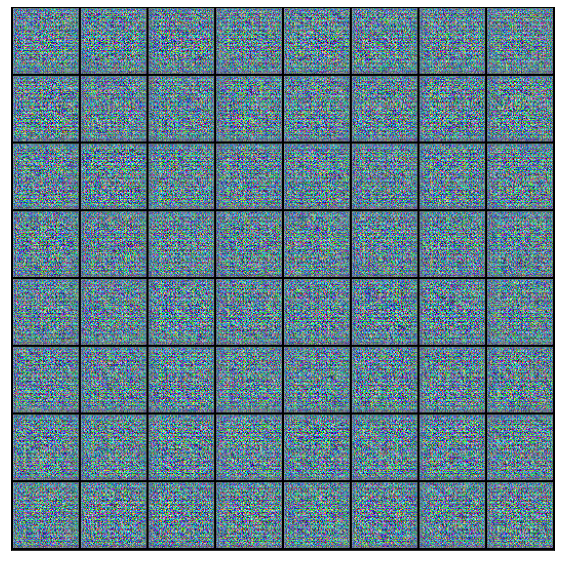

In [24]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent size
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

The generator is just generating random noise as it is not trained

## Discriminator Training

## Save the Progress

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="image-generation-gans")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/developer-jnk/image-generation-gans


'https://jovian.ai/developer-jnk/image-generation-gans'